## DNA Sequencing With Machine Learning

In this notebook, I will apply a classification model that can predict a gene's function based on the DNA sequence of the coding sequence alone.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
human_data = pd.read_table('data/human_data.txt')
human_data.head()

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


### We have three different species of type DNA sequence data each species have their own type of DNA classes.

In [3]:
chimp_data = pd.read_table('data/chimp_data.txt')
chimp_data.head()

,sequence,class
0,ATGCCCCAACTAAATACCGCCGTATGACCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTATTCGCTTCATTCGCTGCCCCCACAATCCTAG...,4
2,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
3,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
4,ATGGGCAGCGCCAGCCCGGGTCTGAGCAGCGTGTCCCCCAGCCACC...,6


In [4]:
dog_data = pd.read_table('data/dog_data.txt')
dog_data.head()

,sequence,class
0,ATGCCACAGCTAGATACATCCACCTGATTTATTATAATCTTTTCAA...,4
1,ATGAACGAAAATCTATTCGCTTCTTTCGCTGCCCCCTCAATAATAG...,4
2,ATGGAAACACCCTTCTACGGCGATGAGGCGCTGAGCGGCCTGGGCG...,6
3,ATGTGCACTAAAATGGAACAGCCCTTCTACCACGACGACTCATACG...,6
4,ATGAGCCGGCAGCTAAACAGAAGCCAGAACTGCTCCTTCAGTGACG...,0


# Each of them have 7 classes of DNA

### Here are the definitions for each of the 7 classes and how many there are in the human training data.  They are gene sequence function groups.

In [5]:
human_dna_classes = ['G protein coupled receptors','Tyrosine kinase','Tyrosine phosphatase',
'Synthetase','Synthase','Ion channel','Transcription factor']

We first take the long biological sequence and break it down into k-mer length overlapping “words”. For example, if we use "words" of length 6 (hexamers), “ATGCATGCA” becomes: ‘ATGCAT’, ‘TGCATG’, ‘GCATGC’, ‘CATGCA’. Hence our example sequence is broken down into 4 hexamer words.

Here we are using hexamer “words” but that is arbitrary and word length can be tuned to suit the particular situation. The word length and amount of overlap need to be determined empirically for any given application.

In genomics, we refer to these types of manipulations as "k-mer counting", or counting the occurances of each possible k-mer sequence. There are specialized tools for this, but the Python natural language processing tools make it super easy.

Here is a function that can be used to convert any sequence (string) to overlapping k-mer words:

###### Let's define a function to collect all possible overlapping k-mers of a specified length from any sequence string. We will basically apply the k-mers to the complete sequences.

In [6]:
# function to convert sequence strings into k-mer words, default size = 6 (hexamer words)
def getKmers(sequence, size = 6):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

###### Now we can convert our training data sequences into short overlapping  k-mers of legth 6.  Lets do that for each species of data we have using our getKmers function.

In [7]:
human_data['words'] = human_data['sequence'].apply(lambda x : getKmers(x))

In [8]:
human_data.head()

,sequence,class,words
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4,"[atgccc, tgcccc, gcccca, ccccaa, cccaac, ccaac..."
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4,"[atgaac, tgaacg, gaacga, aacgaa, acgaaa, cgaaa..."
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3,"[atgcaa, tgcaac, gcaaca, caacag, aacagc, acagc..."


In [9]:
chimp_data['words'] = chimp_data['sequence'].apply(lambda x : getKmers(x))
dog_data['words'] = dog_data['sequence'].apply(lambda x : getKmers(x))
del human_data['sequence'], chimp_data['sequence'], dog_data['sequence']

###### Using CountVector of scikit learn

In [10]:
human_texts = list(human_data['words'])
for item in range(len(human_texts)):
    human_texts[item] = ' '.join(human_texts[item])
y_data = human_data['class'].values                         

In [11]:
pd.DataFrame([human_texts,y_data]).T.head()

,0,1
0,atgccc tgcccc gcccca ccccaa cccaac ccaact caac...,4
1,atgaac tgaacg gaacga aacgaa acgaaa cgaaaa gaaa...,4
2,atgtgt tgtgtg gtgtgg tgtggc gtggca tggcat ggca...,3
3,atgtgt tgtgtg gtgtgg tgtggc gtggca tggcat ggca...,3
4,atgcaa tgcaac gcaaca caacag aacagc acagca cagc...,3


## We will perform the same steps for chimpanzee and dog

In [12]:
chimp_texts = list(chimp_data['words'])
for item in range(len(chimp_texts)):
    chimp_texts[item] = ' '.join(chimp_texts[item])
y_chimp = chimp_data.iloc[:, 0].values                       # y_c for chimp

dog_texts = list(dog_data['words'])
for item in range(len(dog_texts)):
    dog_texts[item] = ' '.join(dog_texts[item])
y_dog = dog_data.iloc[:, 0].values   

## Now we will apply the BAG of WORDS using CountVectorizer

In [13]:
# Creating the Bag of Words model using CountVectorizer()
# This is equivalent to k-mer counting
# The n-gram size of 4 was previously determined by testing
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(4,4))
X = cv.fit_transform(human_texts) # input string
X_chimp = cv.transform(chimp_texts)
X_dog = cv.transform(dog_texts)

In [14]:
print(X.shape)
print(X_chimp.shape)
print(X_dog.shape)

(4380, 232414)
(1682, 232414)
(820, 232414)


### If we have a look at class balance we can see we have relatively balanced dataset.

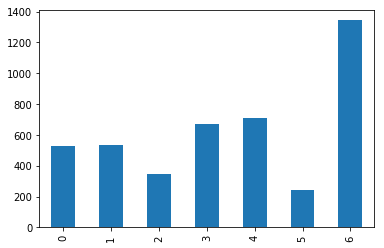

In [15]:
human_data['class'].value_counts().sort_index().plot.bar()

In [16]:
# Splitting the human dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y_data, 
                                                    test_size = 0.20, 
                                                    )

In [17]:
print(X_train.shape)
print(X_test.shape)

(3504, 232414)
(876, 232414)


In [18]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB(alpha=0.1)
classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [19]:
y_pred = classifier.predict(X_test)

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       103
           1       1.00      0.96      0.98        99
           2       1.00      0.97      0.99        71
           3       1.00      0.97      0.99       136
           4       0.99      0.96      0.97       134
           5       1.00      0.98      0.99        44
           6       0.94      1.00      0.97       289

    accuracy                           0.97       876
   macro avg       0.98      0.97      0.98       876
weighted avg       0.97      0.97      0.97       876



In [21]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix

Predicted   0   1   2    3    4   5    6
Actual                                  
0          97   0   0    0    0   0    6
1           0  95   0    0    0   0    4
2           0   0  69    0    1   0    1
3           0   0   0  132    0   0    4
4           2   0   0    0  128   0    4
5           1   0   0    0    0  43    0
6           1   0   0    0    0   0  288
accuracy = 0.973 
precision = 0.974 
recall = 0.973 
f1 = 0.973
